In [1]:
!pip install lime

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import os 
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import shap
import lime
import lime.lime_tabular

C:\Users\Enric\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Feature importance

In [3]:
folder = r'E:\Dropbox\Personale\Ricerca\XAI\00. A.Gatti\cyberattacks\Dataset_simulazione'


In [4]:
target = 'techniques_mitre'

In [5]:
def prepare_dataframe(df, target, scale=False):
    # Preprocess categorical features
    X = df.drop(target, axis=1)
    y = df[target]

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    if scale:
        # Initialize the scaler
        scaler = StandardScaler()

        # Fit the scaler on the training data and transform both training and test data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X, X_train_scaled, y_train, X_test_scaled, y_test
        
    return X, X_train, y_train, X_test, y_test

## XGboost 
note: no scaling is requested with this model

In [6]:
def xgb_features_importance(file, target):

    file_path = os.path.join(folder, file)
    new_df = pd.read_csv(file_path)
    
    X, X_train, y_train, X_test, y_test = prepare_dataframe(new_df, target)

    # Fit the model
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)

    # Get feature importance
    importances = xgb.feature_importances_

    # Ensure X is a DataFrame to get column names
    if isinstance(X, pd.DataFrame):
        feature_names = X.columns
    else:
        feature_names = [f'Feature {i}' for i in range(X.shape[1])]

    # Create a dataframe for better visualization
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance - XGBoost on '+ file)
    plt.gca().invert_yaxis()
    plt.show()



# catBoost


In [28]:
def catboost_features_importance(file, target):
    file_path = os.path.join(folder, file)
    new_df = pd.read_csv(file_path)

    X, X_train, y_train, X_test, y_test = prepare_dataframe(new_df, target)
    
    # Fit the model
    catboost = CatBoostClassifier(verbose=0)
    catboost.fit(X_train, y_train)

 
    # Get feature importance
    importances = catboost.get_feature_importance()

    # Create a dataframe for better visualization
    feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance - CatBoost')
    plt.gca().invert_yaxis()


    # Save the figure in EPS format
    plt.savefig('catboost.pdf', format='pdf', dpi = 1200)
    plt.close()

# Decision Tree

In [8]:
def dt_features_importance(file, target):
    file_path = os.path.join(folder, file)
    new_df = pd.read_csv(file_path)
    X, X_train_scaled, y_train, X_test_scaled, y_test = prepare_dataframe(new_df, target, True) # Scale

    # Fit the model
    dt = DecisionTreeClassifier()
    dt.fit(X_train_scaled, y_train)

    # Get feature importance
    importances = dt.feature_importances_

    # Create a dataframe for better visualization
    feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance - Decision Tree')
    plt.gca().invert_yaxis()
    plt.show()


# Permutation importance

In [9]:
def permutation_features_importance(file, target):
    file_path = os.path.join(folder, file)
    new_df = pd.read_csv(file_path)
    X, X_train_scaled, y_train, X_test_scaled, y_test = prepare_dataframe(new_df, target, True) # Scale

    # Fit the model (using any model, e.g., RandomForest)
    rf = RandomForestClassifier()
    rf.fit(X_train_scaled, y_train)

    # Compute permutation importance
    result = permutation_importance(rf, X_train_scaled, y_train, n_repeats=10, random_state=42)

    # Get feature importance
    importances = result.importances_mean

    # Create a dataframe for better visualization
    feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Permutation Feature Importance - RandomForest')
    plt.gca().invert_yaxis()
    plt.show()


# SHAP

In [10]:
def shap_features_importance(file, target):
    file_path = os.path.join(folder, file)
    new_df = pd.read_csv(file_path)
    X, X_train, y_train, X_test, y_test = prepare_dataframe(new_df, target)

    # Fit the model (using any model, e.g., XGBoost)
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)

    # Create a SHAP explainer
    explainer = shap.TreeExplainer(xgb)
    shap_values = explainer.shap_values(X_train)

    # Plot feature importance
    shap.summary_plot(shap_values, X_train)

# LIME

In [11]:
def lime_features_importance(file, target):
    file_path = os.path.join(folder, file)
    new_df = pd.read_csv(file_path)
     
    X, X_train_scaled, y_train, X_test_scaled, y_test = prepare_dataframe(new_df, target, True) # Scale

    # Fit the model (using any model, e.g., RandomForest)
    rf = RandomForestClassifier()
    rf.fit(X_train_scaled, y_train)

    # Create a LIME explainer
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train_scaled, feature_names=X.columns, class_names=['Class_0', 'Class_1'], mode='classification')

    # Explain a single prediction
    i = 0  # index of the instance to explain
    exp = explainer.explain_instance(X_test_scaled[i], rf.predict_proba, num_features=len(X.columns))

    # Get the feature importance
    feature_importance = exp.as_list()

    # Convert to DataFrame for better visualization
    feature_importance_df = pd.DataFrame(feature_importance, columns=['Feature', 'Importance'])

    # Sort by importance
    feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance - LIME')
    plt.gca().invert_yaxis()
    plt.show()

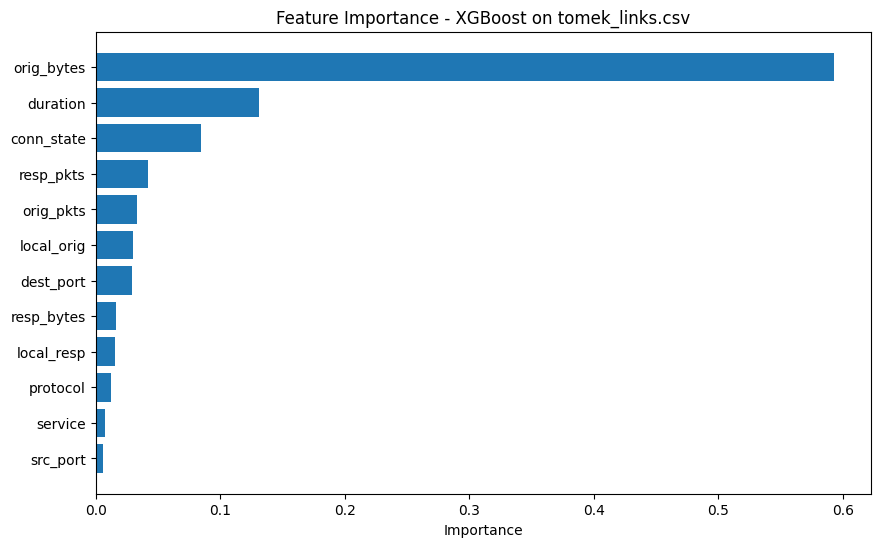

In [12]:
xgb_features_importance("tomek_links.csv", target)

In [29]:
catboost_features_importance("tomek_links.csv", target)

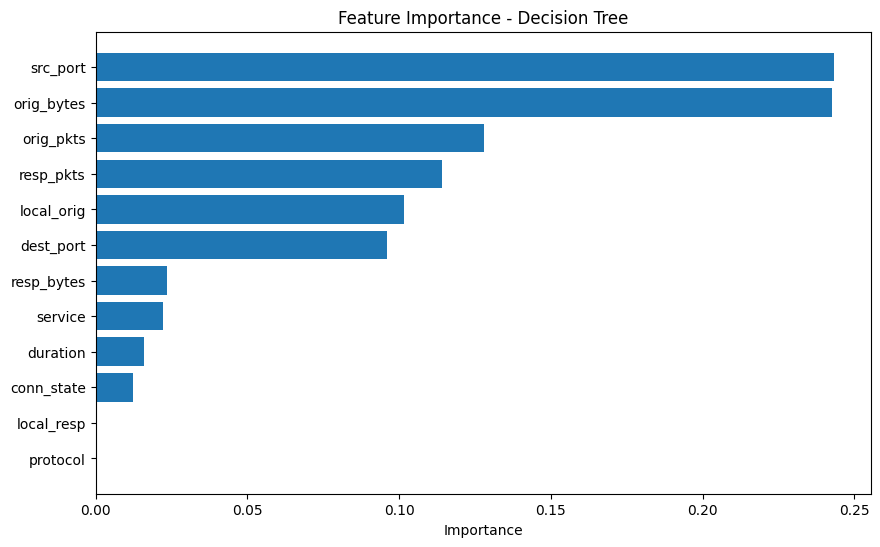

In [16]:
dt_features_importance("smoteenn.csv", target)

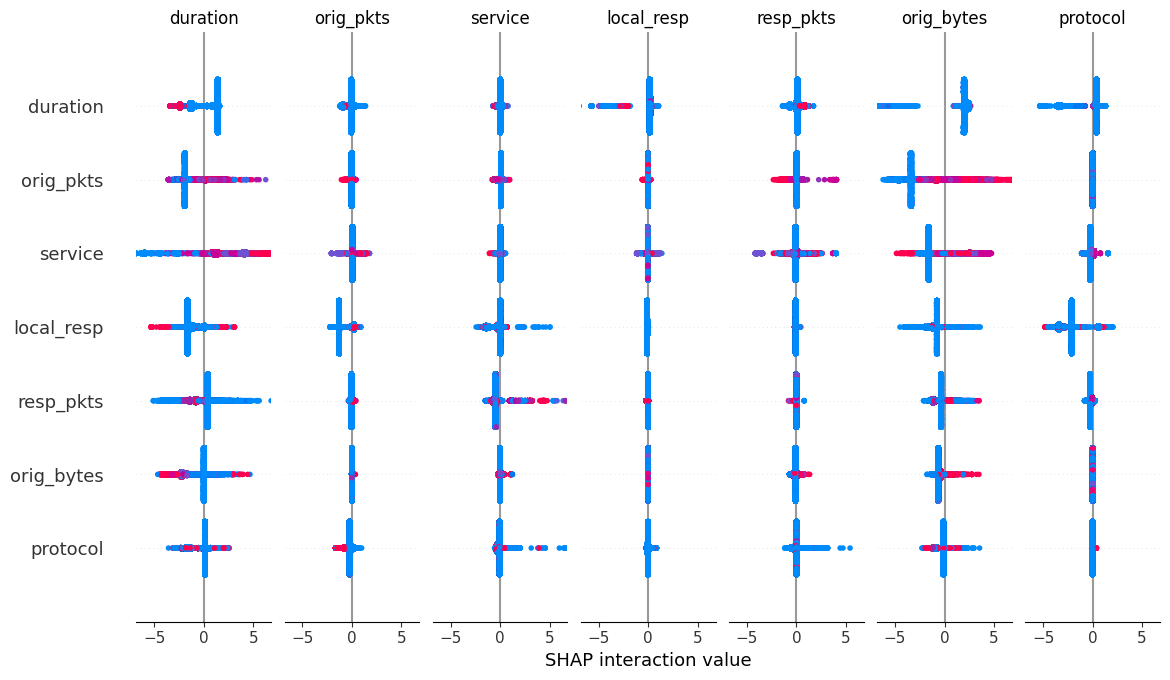

In [17]:
shap_features_importance("tomek_links.csv", target)

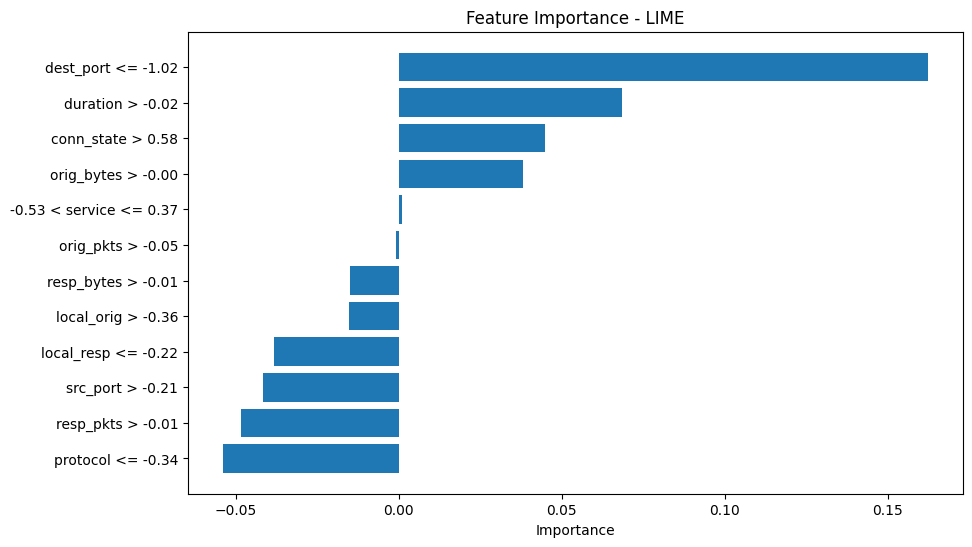

In [18]:
lime_features_importance("tomek_links.csv", target)